In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import bte
import datetime as dt

We begin by reading in our proposal data. To create `public-2023-03-30.all.masked.proposed.tsv` and `public-2023-03-30.all.masked.proposed.pb`, you must first obtain the relevant phylogeny from the UCSC repository.

`
wget http://hgdownload.soe.ucsc.edu/goldenPath/wuhCor1/UShER_SARS-CoV-2/2023/03/30/public-2023-03-30.all.masked.pb.gz`


`wget http://hgdownload.soe.ucsc.edu/goldenPath/wuhCor1/UShER_SARS-CoV-2/2023/03/30/public-2023-03-30.metadata.tsv.gz`

And change the filenames to match.

`mv public-2023-03-30.metadata.tsv.gz public-2023-03-30.all.masked.metadata.tsv.gz`

Then, you apply the [autolin pipeline](https://github.com/jmcbroome/autolin). Alternatively, autolin includes a rule to automatically fetch the relevant data.

`snakemake --cores 1 --snakefile flag_lineages.smk public-2023-03-30.all.masked.proposed.pb`

This will produce the tsv and pb file used below.

In [16]:
pdf = pd.read_csv("public-2023-03-30.all.masked.proposed.tsv",sep='\t')
pdf

,parent,parent_nid,proposed_sublineage,proposed_sublineage_nid,proposed_sublineage_score,proposed_sublineage_size
0,B.1.1.529,node_686702,auto.B.1.1.529.6,node_1127589,2067.210087,2756
1,XBB,node_1086834,auto.XBB.9,node_1109611,8.250000,22
2,XBB.1,node_1087133,auto.XBB.1.2,node_1087253,35.003911,209
3,XBB.2,node_1109076,auto.XBB.2.9,node_1109281,25.804878,51
4,XBB.4,node_1086863,auto.XBB.4.2,node_1086875,6.302083,11
...,...,...,...,...,...,...
59,XBF.1,node_1129006,auto.XBF.1.1,node_1129009,36.716204,57
60,XBP,node_990244,auto.XBP.1,node_990249,3.840000,19
61,XBF.4,node_1129025,auto.XBF.4.1,node_1129032,26.638646,109
62,XBF.3,node_1129148,auto.XBF.3.1,node_1129176,7.535867,18


In [17]:
pdf.proposed_sublineage_size.describe()

count      64.000000
mean      131.953125
std       379.132403
min        10.000000
25%        17.500000
50%        50.500000
75%        91.500000
max      2756.000000
Name: proposed_sublineage_size, dtype: float64

In [69]:
#get the complete set of samples associated with this initial designation set and track their behavior over the next month.
t = bte.MATree("public-2023-03-30.all.masked.proposed.pb")
t

Finished 'from_pb' in 92.8817 seconds


MATree object with 6690333 leaves.

In [71]:
auto_samples = set()
for nid in pdf.proposed_sublineage_nid:
    for s in t.get_leaves_ids(nid):
        auto_samples.add(s)
len(auto_samples)

8445

Once we have the set of samples associated with the proposals on the original tree, we scan for samples in these groups over the next month, as well as any new samples associated with these trees.

First, we have to obtain the next month's worth of global phylogenies. This repository containing this notebook includes a shell script to download all of the data and another script which iteratively transfers annotations between phylogenies.

`bash download_data.sh`

After the data is made available, we remove any new lineages not present in the 2023-04-01 annotated tree from the subsequent month to prevent lineage collisions or confusion.

`matUtils summary -i public-2023-03-30.all.masked.proposed.pb -C auto_proposed_sample_clades.txt`

`for f in public-2023-04*pb.gz ; do python3 clean_lineages.py -a auto_proposed_sample_clades.txt -t $f ; done`

We need to do some additional data preparation to get files for running matUtils annotate before we begin the loop.

`awk -F'\t' '{print $2"\t"$1}' auto_proposed_sample_clades.txt > auto_proposed_clades_samples.txt`

`matUtils extract -i public-2023-03-30.all.masked.proposed.pb -C auto_proposed_clade_paths.txt`

`awk -F'\t' '{print $1"\t"$3}' auto_proposed_clade_paths.txt > auto_proposed_clade_paths.cleaned.txt`

Then you can begin the loop script.

`annotation_loop.sh`

After the completion of this step, compute the clade memberships for each of the daily samples over the month.

`for f in cleaned*transfer.pb.gz ; do echo $f ; matUtils summary -i $f -C ${f%pb.gz}cladesamples.txt ; done`

These files are read below.

In [216]:
import glob
from tqdm.notebook import tqdm
tdf = {k:[] for k in ['strain','date','lineage']}
target_lins = set(pdf.proposed_sublineage)
for f in sorted(glob.glob("*transfer.cladesamples.txt")):
    print(f)
    substr = f.split(".")[1]
    date = dt.datetime.strptime(substr[substr.find("-")+1:],'%Y-%m-%d')
    with open(f) as inf:
        for entry in tqdm(inf.readlines()):
            sample, ann = entry.strip().split()
            if ann in target_lins:
                auto_samples.add(sample)
            if sample in auto_samples: #record all samples in the original set, or any added to one of those lineages
                tdf['strain'].append(sample)
                tdf['date'].append(date)
                tdf['lineage'].append(ann)
tdf = pd.DataFrame(tdf)
tdf

cleaned.public-2023-04-01.all.masked.transfer.cladesamples.txt


  0%|          | 0/6911841 [00:00<?, ?it/s]

cleaned.public-2023-04-02.all.masked.transfer.cladesamples.txt


  0%|          | 0/6912575 [00:00<?, ?it/s]

cleaned.public-2023-04-03.all.masked.transfer.cladesamples.txt


  0%|          | 0/6913141 [00:00<?, ?it/s]

cleaned.public-2023-04-04.all.masked.transfer.cladesamples.txt


  0%|          | 0/6916044 [00:00<?, ?it/s]

cleaned.public-2023-04-05.all.masked.transfer.cladesamples.txt


  0%|          | 0/6918318 [00:00<?, ?it/s]

cleaned.public-2023-04-06.all.masked.transfer.cladesamples.txt


  0%|          | 0/6919610 [00:00<?, ?it/s]

cleaned.public-2023-04-07.all.masked.transfer.cladesamples.txt


  0%|          | 0/6932726 [00:00<?, ?it/s]

cleaned.public-2023-04-08.all.masked.transfer.cladesamples.txt


  0%|          | 0/6937805 [00:00<?, ?it/s]

cleaned.public-2023-04-09.all.masked.transfer.cladesamples.txt


  0%|          | 0/6937834 [00:00<?, ?it/s]

cleaned.public-2023-04-10.all.masked.transfer.cladesamples.txt


  0%|          | 0/6937986 [00:00<?, ?it/s]

cleaned.public-2023-04-11.all.masked.transfer.cladesamples.txt


  0%|          | 0/6937989 [00:00<?, ?it/s]

cleaned.public-2023-04-12.all.masked.transfer.cladesamples.txt


  0%|          | 0/6938185 [00:00<?, ?it/s]

cleaned.public-2023-04-13.all.masked.transfer.cladesamples.txt


  0%|          | 0/6890384 [00:00<?, ?it/s]

cleaned.public-2023-04-14.all.masked.transfer.cladesamples.txt


  0%|          | 0/6885220 [00:00<?, ?it/s]

cleaned.public-2023-04-15.all.masked.transfer.cladesamples.txt


  0%|          | 0/6886518 [00:00<?, ?it/s]

cleaned.public-2023-04-16.all.masked.transfer.cladesamples.txt


  0%|          | 0/6896341 [00:00<?, ?it/s]

cleaned.public-2023-04-17.all.masked.transfer.cladesamples.txt


  0%|          | 0/6896853 [00:00<?, ?it/s]

cleaned.public-2023-04-18.all.masked.transfer.cladesamples.txt


  0%|          | 0/6908965 [00:00<?, ?it/s]

cleaned.public-2023-04-19.all.masked.transfer.cladesamples.txt


  0%|          | 0/6913788 [00:00<?, ?it/s]

cleaned.public-2023-04-20.all.masked.transfer.cladesamples.txt


  0%|          | 0/6915821 [00:00<?, ?it/s]

cleaned.public-2023-04-21.all.masked.transfer.cladesamples.txt


  0%|          | 0/6920641 [00:00<?, ?it/s]

cleaned.public-2023-04-22.all.masked.transfer.cladesamples.txt


  0%|          | 0/6921635 [00:00<?, ?it/s]

cleaned.public-2023-04-23.all.masked.transfer.cladesamples.txt


  0%|          | 0/6921637 [00:00<?, ?it/s]

cleaned.public-2023-04-24.all.masked.transfer.cladesamples.txt


  0%|          | 0/6921641 [00:00<?, ?it/s]

cleaned.public-2023-04-25.all.masked.transfer.cladesamples.txt


  0%|          | 0/6924058 [00:00<?, ?it/s]

cleaned.public-2023-04-26.all.masked.transfer.cladesamples.txt


  0%|          | 0/6925289 [00:00<?, ?it/s]

cleaned.public-2023-04-27.all.masked.transfer.cladesamples.txt


  0%|          | 0/6927334 [00:00<?, ?it/s]

cleaned.public-2023-04-28.all.masked.transfer.cladesamples.txt


  0%|          | 0/6930322 [00:00<?, ?it/s]

cleaned.public-2023-04-29.all.masked.transfer.cladesamples.txt


  0%|          | 0/6934974 [00:00<?, ?it/s]

cleaned.public-2023-04-30.all.masked.transfer.cladesamples.txt


  0%|          | 0/6935661 [00:00<?, ?it/s]

,strain,date,lineage
0,Switzerland/BE-Risch-1128R14982/2022|OX384622....,2023-04-01,auto.XBB.1.2
1,USA/NY-CDC-LC0952300/2022|OQ072427.1|2022-12-02,2023-04-01,auto.XBB.1.2
2,USA/NJ-CDC-LC0950493/2022|OQ072929.1|2022-12-05,2023-04-01,auto.XBB.1.2
3,England/DHSC-CYF99XU/2022|2022-12-30,2023-04-01,auto.XBB.1.2
4,USA/NY-CDC-LC0964118/2022|OQ123241.1|2022-12-17,2023-04-01,auto.XBB.1.2
...,...,...,...
296563,England/BRBR-327102DA/2023|OX461798.1|2023-03-23,2023-04-30,auto.B.1.1.529.6
296564,England/PHEC-YYEI14G/2023|2023-04-19,2023-04-30,auto.XBB.1.9.2.2
296565,England/PHEC-YYESY4S/2023|2023-04-14,2023-04-30,auto.XBB.1.9.2.2
296566,USA/NC-CORVASEQ-DUBF2UMF230215A5/2023|OQ559343...,2023-04-30,auto.B.1.1.529.6


The new lineages cover 8,951 samples initially, growing to 11,877 samples by the end of the month.

In [217]:
tdf.strain.nunique()

11877

In [218]:
tdf[tdf.date == dt.datetime(year=2023,month=4,day=1)].strain.nunique()

8951

28 samples are annotated with more than one lineage over this period, implying they changed location on the phylogeny and are a source of lineage instability.

In [219]:
sli = tdf.groupby("strain").lineage.nunique()
sli.value_counts()

1    11849
2       28
Name: lineage, dtype: int64

In [220]:
unstable = [i for i in sli.index if sli[i] == 2]
unstable

['IND/2947/2023|OQ701301.1|2023-03-10',
 'Scotland/SCOT-24049/2022|OX435521.1|2022-12-31',
 'Scotland/SCOT-26462/2023|2023-02-21',
 'Scotland/SCOT-26462/2023|OX451476.1|2023-02-21',
 'Scotland/SCOT-26819/2023|2023-02-21',
 'Scotland/SCOT-26819/2023|OX453590.1|2023-02-21',
 'Scotland/SCOT-26821/2023|2023-02-21',
 'Scotland/SCOT-26821/2023|OX453648.1|2023-02-21',
 'Scotland/SCOT-27434/2023|OX457315.1|2023-03-02',
 'Scotland/SCOT-28483/2023|2023-03-12',
 'Scotland/SCOT-28483/2023|OX462874.1|2023-03-12',
 'USA/CA-CDC-QDX48192978/2023|OQ728437.1|2023-03-20',
 'USA/CA-CDC-QDX48192979/2023|OQ728624.1|2023-03-20',
 'USA/FL-CDC-QDX47418754/2023|OQ644056.1|2023-03-01',
 'USA/FL-CDC-QDX48193288/2023|OQ782385.1|2023-03-21',
 'USA/FL-CDC-QDX48587517/2023|OQ827304.1|2023-03-31',
 'USA/LA-BIE-LSUH003690/2023|OQ736767.1|2023-03-20',
 'USA/LA-BIE-LSUH003692/2023|OQ736769.1|2023-03-22',
 'USA/M00621433-F1-1/2023|OQ820697.1|2023-03-29',
 'USA/NJ-CDC-QDX48685195/2023|OQ827907.1|2023-04-03',
 'USA/NV-CDC-L

Four lineages are affected by these samples, with 16 being in auto.XBB.1.5.40.

In [225]:
tdf[tdf.strain.isin(unstable)].groupby("lineage").strain.nunique()

lineage
None                 28
auto.B.1.1.529.6      2
auto.XBB.1.16.1.1     2
auto.XBB.1.5.40      16
auto.XBB.1.5.8.1      8
Name: strain, dtype: int64

Now we create a smaller dataframe summarizing the changes of these 28 samples.

In [227]:
statedf = {k:[] for k in ['strain','moved_from','moved_to','on']}
for strain, sdf in tdf[tdf.strain.isin(unstable)].groupby("strain"):
    datev = sdf.groupby("lineage").date.min()
    statedf['strain'].append(strain)
    statedf['moved_from'].append(datev.idxmin())
    statedf['moved_to'].append(datev.idxmax())
    statedf['on'].append(datev.min()+dt.timedelta(days=1))
statedf = pd.DataFrame(statedf)
statedf

,strain,moved_from,moved_to,on
0,IND/2947/2023|OQ701301.1|2023-03-10,None,auto.XBB.1.16.1.1,2023-04-02
1,Scotland/SCOT-24049/2022|OX435521.1|2022-12-31,auto.B.1.1.529.6,None,2023-04-02
2,Scotland/SCOT-26462/2023|2023-02-21,None,auto.XBB.1.5.8.1,2023-04-02
3,Scotland/SCOT-26462/2023|OX451476.1|2023-02-21,None,auto.XBB.1.5.8.1,2023-04-15
4,Scotland/SCOT-26819/2023|2023-02-21,None,auto.XBB.1.5.8.1,2023-04-02
5,Scotland/SCOT-26819/2023|OX453590.1|2023-02-21,None,auto.XBB.1.5.8.1,2023-04-15
6,Scotland/SCOT-26821/2023|2023-02-21,None,auto.XBB.1.5.8.1,2023-04-02
7,Scotland/SCOT-26821/2023|OX453648.1|2023-02-21,None,auto.XBB.1.5.8.1,2023-04-15
8,Scotland/SCOT-27434/2023|OX457315.1|2023-03-02,None,auto.B.1.1.529.6,2023-04-02
9,Scotland/SCOT-28483/2023|2023-03-12,None,auto.XBB.1.5.8.1,2023-04-06


In [228]:
statedf['gained'] = (statedf.moved_to.apply(lambda x:x != 'None'))
statedf

,strain,moved_from,moved_to,on,gained
0,IND/2947/2023|OQ701301.1|2023-03-10,None,auto.XBB.1.16.1.1,2023-04-02,True
1,Scotland/SCOT-24049/2022|OX435521.1|2022-12-31,auto.B.1.1.529.6,None,2023-04-02,False
2,Scotland/SCOT-26462/2023|2023-02-21,None,auto.XBB.1.5.8.1,2023-04-02,True
3,Scotland/SCOT-26462/2023|OX451476.1|2023-02-21,None,auto.XBB.1.5.8.1,2023-04-15,True
4,Scotland/SCOT-26819/2023|2023-02-21,None,auto.XBB.1.5.8.1,2023-04-02,True
5,Scotland/SCOT-26819/2023|OX453590.1|2023-02-21,None,auto.XBB.1.5.8.1,2023-04-15,True
6,Scotland/SCOT-26821/2023|2023-02-21,None,auto.XBB.1.5.8.1,2023-04-02,True
7,Scotland/SCOT-26821/2023|OX453648.1|2023-02-21,None,auto.XBB.1.5.8.1,2023-04-15,True
8,Scotland/SCOT-27434/2023|OX457315.1|2023-03-02,None,auto.B.1.1.529.6,2023-04-02,True
9,Scotland/SCOT-28483/2023|2023-03-12,None,auto.XBB.1.5.8.1,2023-04-06,True


In [229]:
statedf.gained.value_counts()

True     20
False     8
Name: gained, dtype: int64

In [230]:
statedf[statedf.gained].moved_to.value_counts()

auto.XBB.1.5.40      9
auto.XBB.1.5.8.1     8
auto.XBB.1.16.1.1    2
auto.B.1.1.529.6     1
Name: moved_to, dtype: int64

In [231]:
statedf[~statedf.gained].moved_from.value_counts()

auto.XBB.1.5.40     7
auto.B.1.1.529.6    1
Name: moved_from, dtype: int64

Only 0.75% of samples in auto.XBB.1.5.40 are unstable in this way.

In [232]:
total = tdf[tdf.lineage == "auto.XBB.1.5.40"].strain.nunique()
16 / total, total

(0.0075507314771118455, 2119)

Let's create another, simpler table for inclusion in the supplementary data.

In [233]:
simplestate = {k:[] for k in ['Strain','Moved','Lineage','On Date']}
for i,row in statedf.iterrows():
    if row.moved_from == "None":
        simplestate['Strain'].append(row.strain)
        simplestate['Moved'].append("To")
        simplestate['Lineage'].append(row.moved_to)
        simplestate['On Date'].append(row.on)
    else:
        simplestate['Strain'].append(row.strain)
        simplestate['Moved'].append("From")
        simplestate['Lineage'].append(row.moved_from)
        simplestate['On Date'].append(row.on)        
simplestate = pd.DataFrame(simplestate)
simplestate

,Strain,Moved,Lineage,On Date
0,IND/2947/2023|OQ701301.1|2023-03-10,To,auto.XBB.1.16.1.1,2023-04-02
1,Scotland/SCOT-24049/2022|OX435521.1|2022-12-31,From,auto.B.1.1.529.6,2023-04-02
2,Scotland/SCOT-26462/2023|2023-02-21,To,auto.XBB.1.5.8.1,2023-04-02
3,Scotland/SCOT-26462/2023|OX451476.1|2023-02-21,To,auto.XBB.1.5.8.1,2023-04-15
4,Scotland/SCOT-26819/2023|2023-02-21,To,auto.XBB.1.5.8.1,2023-04-02
5,Scotland/SCOT-26819/2023|OX453590.1|2023-02-21,To,auto.XBB.1.5.8.1,2023-04-15
6,Scotland/SCOT-26821/2023|2023-02-21,To,auto.XBB.1.5.8.1,2023-04-02
7,Scotland/SCOT-26821/2023|OX453648.1|2023-02-21,To,auto.XBB.1.5.8.1,2023-04-15
8,Scotland/SCOT-27434/2023|OX457315.1|2023-03-02,To,auto.B.1.1.529.6,2023-04-02
9,Scotland/SCOT-28483/2023|2023-03-12,To,auto.XBB.1.5.8.1,2023-04-06


In [234]:
simplestate.to_csv("unstable_samples.csv",index=False)

Next, we turn our attention to samples that are present in earlier trees, but do not appear in the final 2023-04-30 tree. About 7% of samples included in auto lineage designations appear to be dropped at some point over the month.

In [242]:
dmvc = tdf.groupby('strain').date.max().value_counts(normalize=True)
dmvc

2023-04-30    0.929275
2023-04-12    0.038478
2023-04-13    0.024249
2023-04-05    0.002694
2023-04-17    0.001431
2023-04-01    0.000842
2023-04-03    0.000842
2023-04-18    0.000589
2023-04-06    0.000505
2023-04-04    0.000421
2023-04-15    0.000421
2023-04-07    0.000253
Name: date, dtype: float64

In [243]:
dropped = tdf.groupby('strain').date.max().apply(lambda x:x != dt.datetime(year=2023,month=4,day=30))
dropped.value_counts() #840 samples were dropped or renamed.

False    11037
True       840
Name: date, dtype: int64

In [244]:
[d for d in dropped.index if dropped[d]]

['COG-UK/BRBR-32702657|OX458054.1|2023-03-11',
 'COG-UK/BRBR-327031FB|OX457206.1|2023-03-13',
 'COG-UK/BRBR-32703586|OX458170.1|2023-03-12',
 'COG-UK/BRBR-32704F0F|OX457348.1|2023-03-12',
 'COG-UK/BRBR-327079B3|OX457868.1|2023-03-14',
 'COG-UK/BRBR-32707ADE|OX458005.1|2023-03-15',
 'COG-UK/PLYM-32704AA4|OX457543.1|2023-03-13',
 'COG-UK/QEUH-32700B87|OX456182.1|2023-03-06',
 'COG-UK/SCOT-27352|OX458253.1|2023-03-03',
 'COG-UK/SCOT-27361|OX458298.1|2023-03-01',
 'COG-UK/SCOT-27480|OX459173.1|2023-03-10',
 'COG-UK/SCOT-27493|OX459182.1|2023-03-10',
 'COG-UK/SCOT-27626|OX460743.1|2023-03-08',
 'COG-UK/SCOT-27666|OX460643.1|2023-03-08',
 'COG-UK/SCOT-27744|OX460710.1|2023-03-07',
 'COG-UK/SCOT-27761|OX460721.1|2023-03-07',
 'COG-UK/SCOT-27762|OX460625.1|2023-03-08',
 'COG-UK/SCOT-27784|OX460509.1|2023-03-10',
 'England/BRBR-327092F2/2023|2023-03-16',
 'England/BRBR-32709A18/2023|2023-03-16',
 'England/BRBR-3270AD2D/2023|2023-03-17',
 'England/BRBR-3270C0B9/2023|2023-03-20',
 'England/BRBR-3

These missing samples may have been retracted, filtered, or renamed. 38 of the automated lineage annotations included at least one of these samples.

In [245]:
tdf['dropped'] = tdf.strain.isin([d for d in dropped.index if dropped[d]])
tdf[tdf.dropped].lineage.nunique() 

38

It appears that on April 12th and 13th 2023, several hundred samples were dropped from the tree.

In [246]:
tdf.groupby("strain").date.max().value_counts()

2023-04-30    11037
2023-04-12      457
2023-04-13      288
2023-04-05       32
2023-04-17       17
2023-04-01       10
2023-04-03       10
2023-04-18        7
2023-04-06        6
2023-04-04        5
2023-04-15        5
2023-04-07        3
Name: date, dtype: int64

(array([19448., 19452., 19456., 19460., 19464., 19468., 19472., 19476.,
        19478.]),
 [Text(19448.0, 0, '2023-04-01'),
  Text(19452.0, 0, '2023-04-05'),
  Text(19456.0, 0, '2023-04-09'),
  Text(19460.0, 0, '2023-04-13'),
  Text(19464.0, 0, '2023-04-17'),
  Text(19468.0, 0, '2023-04-21'),
  Text(19472.0, 0, '2023-04-25'),
  Text(19476.0, 0, '2023-04-29'),
  Text(19478.0, 0, '2023-05-01')])

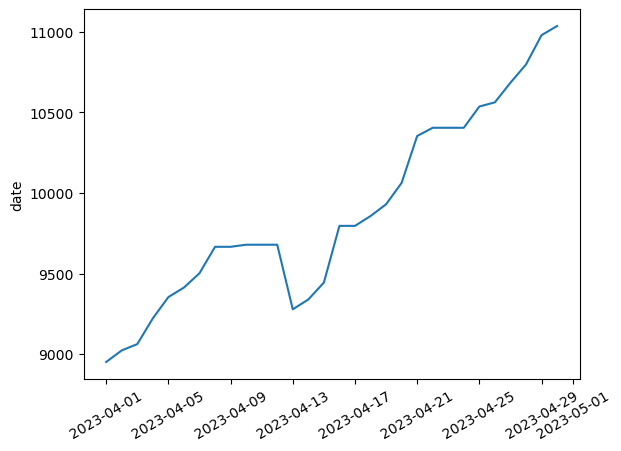

In [247]:
ax = sns.lineplot(tdf.date.value_counts().sort_index())
plt.xticks(rotation=30)

Some lineages were significantly affected, like "auto.XBB.1.29.1", which went from 12 to 7 samples on that day and failed to grow for the rest of the month.

In [249]:
tdf[tdf.lineage == 'auto.XBB.1.29.1'].groupby("date").strain.nunique()

date
2023-04-01    12
2023-04-02    12
2023-04-03    12
2023-04-04    12
2023-04-05    12
2023-04-06    12
2023-04-07    12
2023-04-08    12
2023-04-09    12
2023-04-10    12
2023-04-11    12
2023-04-12    12
2023-04-13     7
2023-04-14     7
2023-04-15     7
2023-04-16     7
2023-04-17     7
2023-04-18     7
2023-04-19     7
2023-04-20     7
2023-04-21     7
2023-04-22     7
2023-04-23     7
2023-04-24     7
2023-04-25     7
2023-04-26     7
2023-04-27     7
2023-04-28     7
2023-04-29     7
2023-04-30     7
Name: strain, dtype: int64

In [250]:
tdf[(tdf.lineage == 'auto.XBB.1.29.1') & (tdf.date == dt.datetime(year=2023,month=4,day=1))]

,strain,date,lineage,dropped
1224,Scotland/SCOT-26391/2023|OX451266.1|2023-02-08,2023-04-01,auto.XBB.1.29.1,False
1225,OX451444.1|2023-02-17,2023-04-01,auto.XBB.1.29.1,True
1226,OX451312.1|2023-02-08,2023-04-01,auto.XBB.1.29.1,True
1227,OX451266.1|2023-02-08,2023-04-01,auto.XBB.1.29.1,True
1228,OX451296.1|2023-02-14,2023-04-01,auto.XBB.1.29.1,True
1229,OX451307.1|2023-02-14,2023-04-01,auto.XBB.1.29.1,True
1230,OX451313.1|2023-02-13,2023-04-01,auto.XBB.1.29.1,True
1231,Scotland/SCOT-26515/2023|2023-02-17,2023-04-01,auto.XBB.1.29.1,False
1232,Scotland/SCOT-26390/2023|OX451312.1|2023-02-08,2023-04-01,auto.XBB.1.29.1,False
1233,Scotland/SCOT-26405/2023|OX451296.1|2023-02-14,2023-04-01,auto.XBB.1.29.1,False


Inspecting these samples more closely, we can see that several appear to be redundant- "OX451266.1|2023-02-08" is likely the same sample as "Scotland/SCOT-26391/2023|OX451266.1|2023-02-08". Presumably, the maintainers of the database containing these phylogenies realized this duplication error on 2023-04-12 and dropped the duplicate IDs for the next day's tree.

In [251]:
tdf[tdf.lineage == 'auto.XBB.1.29.1'].strain.value_counts()

Scotland/SCOT-26391/2023|OX451266.1|2023-02-08    30
Scotland/SCOT-26515/2023|2023-02-17               30
Scotland/SCOT-26390/2023|OX451312.1|2023-02-08    30
Scotland/SCOT-26405/2023|OX451296.1|2023-02-14    30
Scotland/SCOT-26404/2023|OX451307.1|2023-02-14    30
Scotland/SCOT-26400/2023|OX451313.1|2023-02-13    30
Scotland/SCOT-26515/2023|OX451444.1|2023-02-17    17
OX451444.1|2023-02-17                             13
OX451312.1|2023-02-08                             12
OX451266.1|2023-02-08                             12
OX451296.1|2023-02-14                             12
OX451307.1|2023-02-14                             12
OX451313.1|2023-02-13                             12
Name: strain, dtype: int64